<a href="https://colab.research.google.com/github/aissam-out/Predicting-Heart-Disease/blob/master/NN_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import resources

In [0]:
# import modules
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
%matplotlib inline

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# loading the dataset
downloaded_train_v = drive.CreateFile({'id':'******************'}) 
downloaded_train_l = drive.CreateFile({'id':'******************'}) 

downloaded_train_v.GetContentFile('train_values.csv')
downloaded_train_l.GetContentFile('train_labels.csv')

df_train_v = pd.read_csv("train_values.csv")
df_train_l = pd.read_csv("train_labels.csv")

# Data Exploration & preprocessing

In [0]:
# replace strings with numbers
df_train_v['thal'] = df_train_v['thal'].replace({'normal':0,'reversible_defect':1, 'fixed_defect':2})
df_train_v = pd.get_dummies(df_train_v, columns=['slope_of_peak_exercise_st_segment','chest_pain_type','num_major_vessels'])

In [0]:
# Feature engineering 1
df_train_v["added"]=df_train_v['oldpeak_eq_st_depression']/df_train_v['max_heart_rate_achieved']

In [0]:
# drop ID column
df_train_v = df_train_v.drop("patient_id", axis=1)
df_train_l = df_train_l.drop("patient_id", axis=1)

In [0]:
# Feature engineering 2 : extra drops 
df_train_v = df_train_v.drop(["num_major_vessels_3", 
                              "fasting_blood_sugar_gt_120_mg_per_dl", 
                              "num_major_vessels_1",
                              "num_major_vessels_2", 
                              "slope_of_peak_exercise_st_segment_3", 
                              "chest_pain_type_1", 
                              "chest_pain_type_2"], 
                             axis=1)

In [0]:
df_train_v.sample()

,thal,resting_blood_pressure,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,slope_of_peak_exercise_st_segment_1,slope_of_peak_exercise_st_segment_2,chest_pain_type_3,chest_pain_type_4,num_major_vessels_0,added
78,1,145,2,282,2.8,1,60,142,1,0,1,0,1,0,0.019718


In [0]:
pd.DataFrame(df_train_v.columns).T.iloc[:,0:9]

,0,1,2,3,4,5,6,7,8
0,thal,resting_blood_pressure,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina


In [0]:
pd.DataFrame(df_train_v.columns).T.iloc[:,9:]

,9,10,11,12,13,14
0,slope_of_peak_exercise_st_segment_1,slope_of_peak_exercise_st_segment_2,chest_pain_type_3,chest_pain_type_4,num_major_vessels_0,added


In [0]:
# convert to values
df_train_v = (df_train_v.values).astype('float32')
df_train_v = preprocessing.scale(df_train_v)
df_train_l = df_train_l.values.astype('float32')

In [0]:
df_train_v.shape

(180, 15)

In [0]:
# VALIDATION
df_train_v, df_VALIDATION_v, df_train_l, df_VALIDATION_l = train_test_split(df_train_v, df_train_l, test_size=0.055)

In [0]:
df_VALIDATION_v.shape

(10, 15)

In [0]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(df_train_v, df_train_l, test_size=0.2)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

# convert column-vector to 1d array
y_train = np.ravel(y_train)

x_train shape: (136, 15)
136 train samples


# Training

In [0]:
from keras import regularizers, backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [0]:
verbose = 0
epochs = 50
model_name =""
batch_size = 32
global_evaluation = {}

def create_model(model):
  model.add(Dense(15, input_dim=15, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(15, kernel_regularizer=regularizers.l2(0.2), activation='relu'))
  model.add(Dense(15, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(13, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
  model.add(Dense(13, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(11, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
  model.add(Dense(11, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(9, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
  model.add(Dense(7, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(3, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  
  return model

## Useful functions

In [0]:
def fit_model(model, x_train, y_train, epochs, batch_size):
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # Fit the model
  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
  
  return history

def plot_model(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
def evaluation(model, x_train, x_test, y_train, y_test, model_name):
  scores_tr = model.evaluate(x_train, y_train)
  print("\n%s: %.2f%%" % (model.metrics_names[1], scores_tr[1]*100))
  scores_te = model.evaluate(x_test, y_test)
  print("\n%s: %.2f%%" % (model.metrics_names[1], scores_te[1]*100))
  global_evaluation.update({model_name : [(scores_tr[1]*100).round(2), (scores_te[1]*100).round(2), scores_tr[0].round(2), scores_te[0].round(2)]})

  
def prep_results(model):
  predictions_indabax = model.predict_proba(test_indabax)
  submission = predictions_indabax
  results = pd.DataFrame(submission)
  df_sub_indabax["heart_disease_present"] = results
  
  return df_sub_indabax

def agregation_model(model, x_train, x_test, y_train, y_test, epochs=1000, batch_size=20, model_name=model_name):
  create_model(model)
  history = fit_model(model, x_train, y_train, epochs, batch_size)
  plot_model(history)
  evaluation(model, x_train, x_test, y_train, y_test, model_name)
  df_sub_indabax = prep_results(model)
  
  return df_sub_indabax

def indabax_multi(file, epochs=epochs, batch_size=batch_size, model_name=model_name):
  x_train, x_test, y_train, y_test = train_test_split(df_train_v, df_train_l, test_size=0.2)
  y_train = np.ravel(y_train)
  
  model = Sequential()
  df_sub_indabax = agregation_model(model, x_train, x_test, y_train, y_test, epochs=epochs, batch_size=batch_size, model_name=model_name)
  df_sub_indabax.to_csv(file, header=True, index=False)
  
  return model

# Indabax test

In [0]:
# load the test set
downloaded_test_v = drive.CreateFile({'id':'*********************'})
downloaded_test_v.GetContentFile('test_values.csv')

df_test_v = pd.read_csv("test_values.csv")
test_indabax = df_test_v.copy()

# preprocess test set
test_indabax['thal'] = test_indabax['thal'].replace({'normal':0,'reversible_defect':1, 'fixed_defect':2})
test_indabax = pd.get_dummies(test_indabax, columns=['slope_of_peak_exercise_st_segment','chest_pain_type','num_major_vessels'])
test_indabax["added"]=test_indabax['oldpeak_eq_st_depression']/test_indabax['max_heart_rate_achieved']
test_indabax = test_indabax.drop(["patient_id",
                                  "num_major_vessels_3",
                                  "fasting_blood_sugar_gt_120_mg_per_dl",
                                  "num_major_vessels_1",
                                  "num_major_vessels_2",
                                  "slope_of_peak_exercise_st_segment_3",
                                  "chest_pain_type_1",
                                  "chest_pain_type_2"],
                                 axis=1)
test_indabax = (test_indabax.values).astype('float32')
test_indabax = preprocessing.scale(test_indabax)

# load submission form
sub_form = drive.CreateFile({'id':'**********************'})
sub_form.GetContentFile('submission_format.csv')

df_sub = pd.read_csv("submission_format.csv")
df_sub_indabax = df_sub.copy()

# Save results

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Multi tests

In [0]:
backend.clear_session()

## Test 1

Instructions for updating:
Use tf.cast instead.


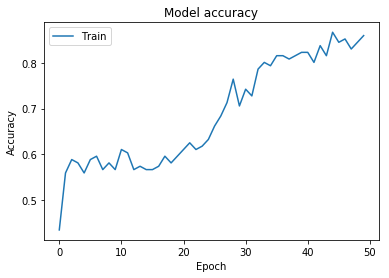

136/136 [==============================] - 0s 1ms/step

acc: 86.76%
34/34 [==============================] - 0s 230us/step

acc: 88.24%


In [0]:
model1 = indabax_multi(file="multi_1.csv", epochs=epochs, batch_size=batch_size, model_name="model_1")

## Test 2

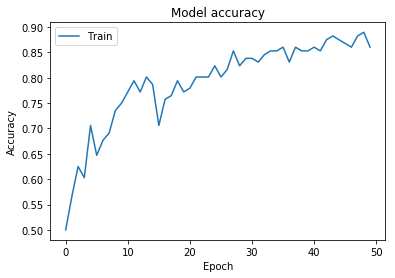

136/136 [==============================] - 0s 2ms/step

acc: 89.71%
34/34 [==============================] - 0s 355us/step

acc: 76.47%


In [0]:
model2 = indabax_multi(file="multi_2.csv", epochs=epochs, batch_size=batch_size, model_name="model_2")

## Test 3

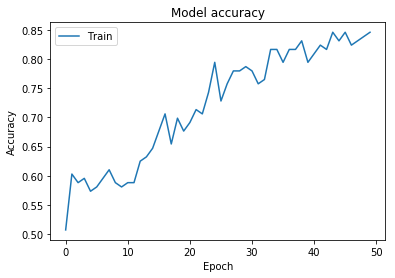

136/136 [==============================] - 0s 3ms/step

acc: 91.18%
34/34 [==============================] - 0s 125us/step

acc: 79.41%


In [0]:
model3 = indabax_multi(file="multi_3.csv", epochs=epochs, batch_size=batch_size, model_name="model_3")

## Test 4

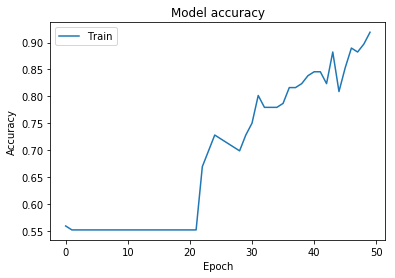

136/136 [==============================] - 0s 4ms/step

acc: 95.59%
34/34 [==============================] - 0s 181us/step

acc: 73.53%


In [0]:
model4 = indabax_multi(file="multi_4.csv", epochs=epochs, batch_size=batch_size, model_name="model_4")

## Test 5

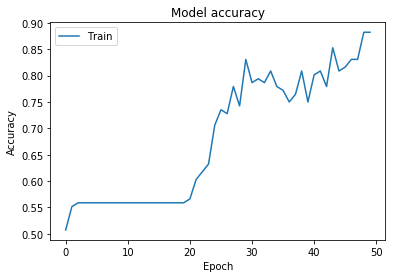

136/136 [==============================] - 1s 4ms/step

acc: 88.97%
34/34 [==============================] - 0s 172us/step

acc: 73.53%


In [0]:
model5 = indabax_multi(file="multi_5.csv", epochs=epochs, batch_size=batch_size, model_name="model_5")

## Test 6

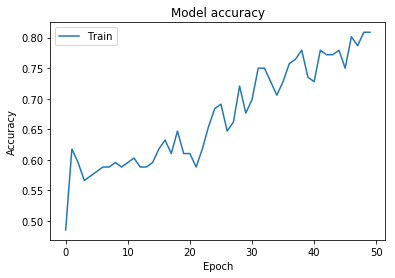

136/136 [==============================] - 1s 6ms/step

acc: 86.03%
34/34 [==============================] - 0s 167us/step

acc: 73.53%


In [0]:
model6 = indabax_multi(file="multi_6.csv", epochs=epochs, batch_size=batch_size, model_name="model_6")

## Test 7

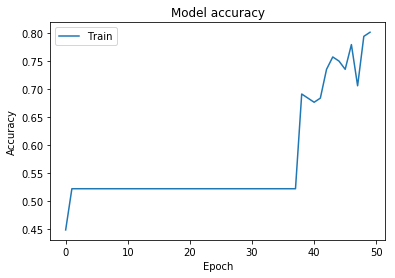

136/136 [==============================] - 1s 6ms/step

acc: 87.50%
34/34 [==============================] - 0s 148us/step

acc: 79.41%


In [0]:
model7 = indabax_multi(file="multi_7.csv", epochs=epochs, batch_size=batch_size, model_name="model_7")

## Test 8

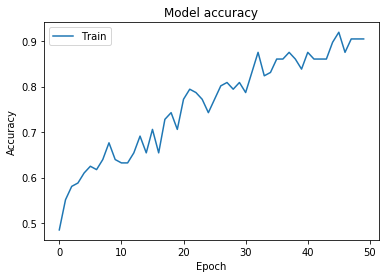

136/136 [==============================] - 1s 7ms/step

acc: 91.91%
34/34 [==============================] - 0s 217us/step

acc: 76.47%


In [0]:
model8 = indabax_multi(file="multi_8.csv", epochs=epochs, batch_size=batch_size, model_name="model_8")

## Test 9

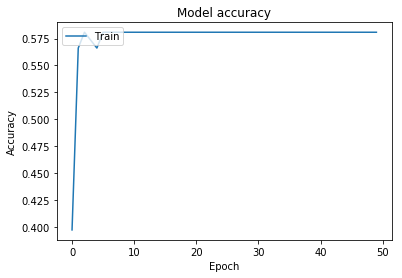

136/136 [==============================] - 1s 8ms/step

acc: 58.09%
34/34 [==============================] - 0s 255us/step

acc: 44.12%


In [0]:
model9 = indabax_multi(file="multi_9.csv", epochs=epochs, batch_size=batch_size, model_name="model_9")

## Test 10

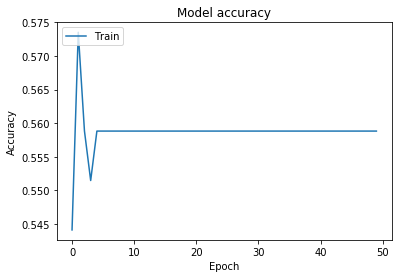

136/136 [==============================] - 1s 9ms/step

acc: 55.88%
34/34 [==============================] - 0s 289us/step

acc: 52.94%


In [0]:
model10 = indabax_multi(file="multi_10.csv", epochs=epochs, batch_size=batch_size, model_name="model_10")

## Further tests

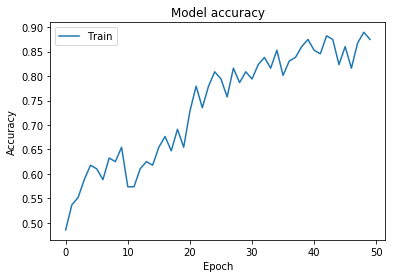

136/136 [==============================] - 1s 9ms/step

acc: 91.18%
34/34 [==============================] - 0s 190us/step

acc: 82.35%


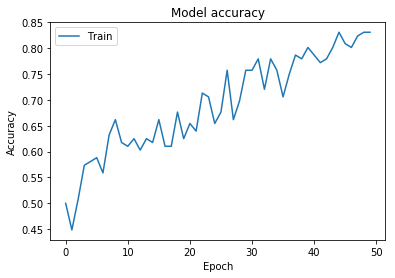

136/136 [==============================] - 1s 10ms/step

acc: 83.82%
34/34 [==============================] - 0s 253us/step

acc: 76.47%


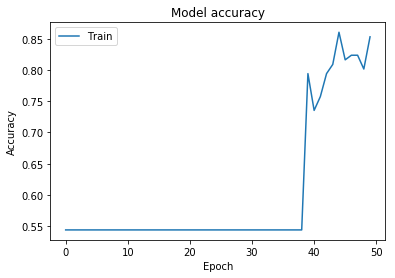

136/136 [==============================] - 1s 11ms/step

acc: 88.97%
34/34 [==============================] - 0s 197us/step

acc: 82.35%


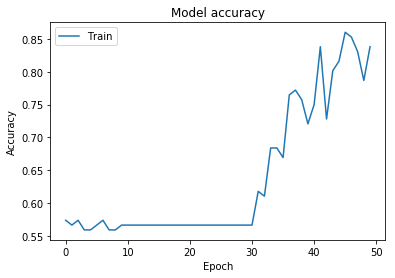

136/136 [==============================] - 2s 12ms/step

acc: 87.50%
34/34 [==============================] - 0s 312us/step

acc: 82.35%


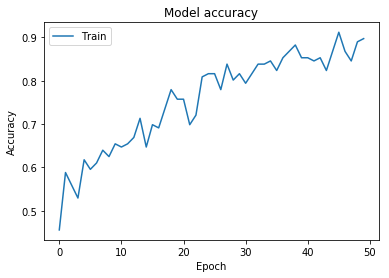

136/136 [==============================] - 2s 12ms/step

acc: 91.18%
34/34 [==============================] - 0s 189us/step

acc: 79.41%


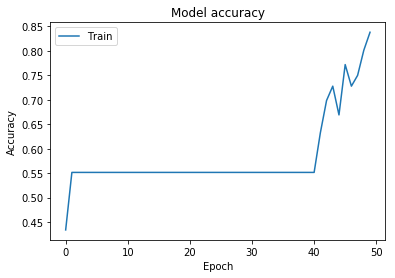

136/136 [==============================] - 2s 13ms/step

acc: 88.24%
34/34 [==============================] - 0s 262us/step

acc: 85.29%


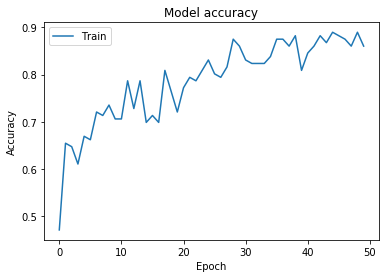

136/136 [==============================] - 2s 14ms/step

acc: 91.91%
34/34 [==============================] - 0s 211us/step

acc: 79.41%


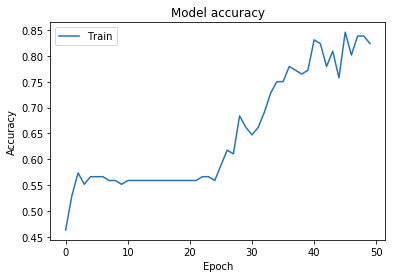

136/136 [==============================] - 2s 14ms/step

acc: 88.24%
34/34 [==============================] - 0s 244us/step

acc: 82.35%


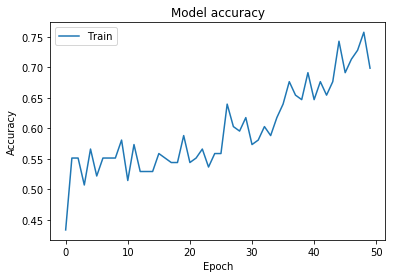

136/136 [==============================] - 2s 15ms/step

acc: 84.56%
34/34 [==============================] - 0s 331us/step

acc: 73.53%


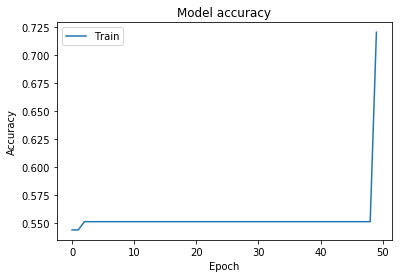

136/136 [==============================] - 2s 16ms/step

acc: 86.76%
34/34 [==============================] - 0s 215us/step

acc: 82.35%


In [0]:
model11 = indabax_multi(file="multi_11.csv", epochs=epochs, batch_size=batch_size, model_name="model_11")
model12 = indabax_multi(file="multi_12.csv", epochs=epochs, batch_size=batch_size, model_name="model_12")
model13 = indabax_multi(file="multi_13.csv", epochs=epochs, batch_size=batch_size, model_name="model_13")
model14 = indabax_multi(file="multi_14.csv", epochs=epochs, batch_size=batch_size, model_name="model_14")
model15 = indabax_multi(file="multi_15.csv", epochs=epochs, batch_size=batch_size, model_name="model_15")
model16 = indabax_multi(file="multi_16.csv", epochs=epochs, batch_size=batch_size, model_name="model_16")
model17 = indabax_multi(file="multi_17.csv", epochs=epochs, batch_size=batch_size, model_name="model_17")
model18 = indabax_multi(file="multi_18.csv", epochs=epochs, batch_size=batch_size, model_name="model_18")
model19 = indabax_multi(file="multi_19.csv", epochs=epochs, batch_size=batch_size, model_name="model_19")
model20 = indabax_multi(file="multi_20.csv", epochs=epochs, batch_size=batch_size, model_name="model_20")

##  Copy to Drive

In [0]:
%cp multi_16.csv gdrive/'My Drive'/'Colab Notebooks'/indabax

# Evaluation

In [0]:
global_evaluation = pd.DataFrame.from_dict(global_evaluation, orient='index',columns=['Train accuracy', 'Test accuracy', 'Train loss', 'Test loss'])

In [0]:
#global_evaluation.sort_values(by=['Train accuracy', 'Test accuracy'], ascending=False)
global_evaluation.sort_values(by=['Test loss'])

,Train accuracy,Test accuracy,Train loss,Test loss
model_1,86.76,88.24,1.58,1.56
model_14,87.50,82.35,1.63,1.63
model_18,88.24,82.35,1.57,1.64
model_13,88.97,82.35,1.54,1.64
model_8,91.91,76.47,1.59,1.65
model_6,86.03,73.53,1.66,1.67
model_20,86.76,82.35,1.71,1.68
model_3,91.18,79.41,1.50,1.69
model_16,88.24,85.29,1.70,1.70
model_11,91.18,82.35,1.59,1.74


In [0]:
mean = pd.DataFrame.from_dict(global_evaluation.mean(axis = 0)).T
mean.rename(index={0:'mean'}, inplace=True)
mean

,Train accuracy,Test accuracy,Train loss,Test loss
mean,85.699,76.1755,1.65,1.7305
